# Simple CNN model using modularCNN

In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from config import PARENT_DIR # set this as path to the directory you cloned into
sys.path.append(f'{PARENT_DIR}\modularCNN')
from lib import layer, network

#### 1. Unpacking cifar-10:

In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
#List of train data files:
data_batches = ['data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5',]
#Unpickling every batch in the list:
train_data_dicts = [unpickle(batch) for batch in data_batches]
#Unpickling test data file:
test_data_dict = unpickle('test_batch')
#Unpickling label names file:
label_names_dicts = unpickle('batches.meta')
label_names = [str(label, 'utf-8') for label in label_names_dicts[b'label_names']]

In [6]:
#Group batches and define train data:
x_train = np.empty(shape=(0,3072),dtype=np.uint8)
y_train = []
for dict in train_data_dicts:
    x_train = np.append(x_train, dict[b'data'], axis = 0)
    y_train += dict[b'labels']
y_train = np.asarray(y_train)

#Define test data:
x_test = np.array(test_data_dict[b'data'])
y_test = np.array(test_data_dict[b'labels'])

#Convert x to image format:
x_train = x_train.reshape(50000,3,32,32).transpose(0,2,3,1)
x_test = x_test.reshape(10000,3,32,32).transpose(0,2,3,1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


We now have the train and test data. Let's try plotting some of the images

In [23]:
#function to plot 6 random images from the dataset:
def plot_6(x, y, y_hat=None):
    fig, ax = plt.subplots(2,3)
    i_list = np.random.randint(low=0, high=10000, size = 6) #generate list of random indices
    i=0
    for row in ax:
        for col in row:
            col.axis('off')
            #get image:
            img = x[i_list[i]]
            col.imshow(img)
            #get label:
            label_no = int(y[i_list[i]])
            label = label_names[label_no]
    
            if type(y_hat) == np.ndarray: #print predictions if they have been made
                predicted_label_no = int(y_hat[i_list[i]])
                predicted_label = label_names[predicted_label_no]
                col.set_title(f'Index: {i_list[i]}\nLabel: {label}\nPredicted: {predicted_label}',
                              loc='left', fontdict={'fontsize': 8})
                fig.suptitle('Example Predictions')
            else: 
                col.set_title(f'Index: {i_list[i]}\nLabel: {label}',
                              loc='left', fontdict={'fontsize': 8})
                fig.suptitle('Example Images')
            
            #update to the next generated index
            i+=1
    plt.show()

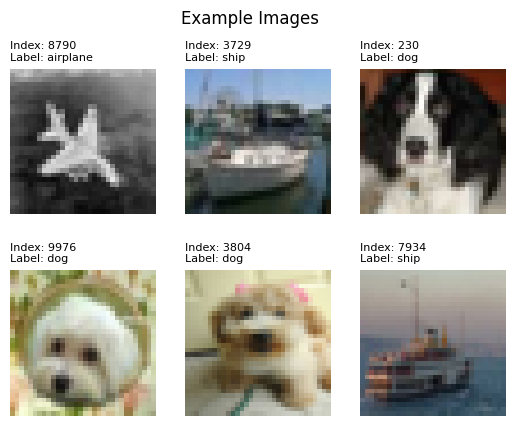

In [24]:
plot_6(x=x_test.astype('int'), y=y_test.astype('int'))

In [9]:
# the images look good, now we process the data for training:

# preprocess input features with min max scaling:
x_train_scaled = x_train / 255
x_test_scaled = x_test / 255

# random parallel shuffle train data for random validation:
p = np.random.permutation(x_train.shape[0])
rand_x_tr = x_train_scaled[p]
rand_y_tr = y_train[p]

#### 2. Building and training a simple CNN model:

In [14]:
# define the model:
cnn = network.Net()
# get the model structure overview (at the moment empty):
cnn.summary()

╒══════════════╤═══════════════╤═════════════════╤════════════════════╕
│ LAYER NAME   │ INPUT SHAPE   │ OUTPUT SHAPE    │   TRAINABLE PARAMS │
╞══════════════╪═══════════════╪═════════════════╪════════════════════╡
│ TOTAL        │               │                 │                  0 │
╘══════════════╧═══════════════╧═════════════════╧════════════════════╛


In [15]:
cnn.add(layer.Convolutional(input_shape=(32,32,3),filters=16,filter_size=3,stride=1,pad=1))
cnn.add(layer.Activation('relu'))
cnn.add(layer.MaxPooling(input_shape=(32,32,16)))

cnn.add(layer.Convolutional(input_shape=(16,16,16),filters=16,filter_size=3,stride=1,pad=1))
cnn.add(layer.Activation('relu'))
cnn.add(layer.MaxPooling(input_shape=(16,16,16)))

cnn.add(layer.Convolutional(input_shape=(8,8,16),filters=32,filter_size=3,stride=1,pad=1))
cnn.add(layer.Activation('leakyrelu'))
cnn.add(layer.MaxPooling(input_shape=(8,8,32)))

cnn.add(layer.Flatten(input_shape=(4,4,32)))
cnn.add(layer.Dense(units_in=512,units_out=10,initial_Wvar=2/512))
cnn.add(layer.Activation('softmax'))

In [16]:
cnn.summary()

╒═══════════════════════╤═══════════════╤═════════════════╤════════════════════╕
│ LAYER NAME            │ INPUT SHAPE   │ OUTPUT SHAPE    │   TRAINABLE PARAMS │
╞═══════════════════════╪═══════════════╪═════════════════╪════════════════════╡
│ Convolutional         │ (32, 32, 3)   │ (32, 32, 16)    │                432 │
├───────────────────────┼───────────────┼─────────────────┼────────────────────┤
│ Activation: relu      │ _             │ _               │                  0 │
├───────────────────────┼───────────────┼─────────────────┼────────────────────┤
│ MaxPooling            │ (32, 32, 16)  │ (16, 16, 16)    │                  0 │
├───────────────────────┼───────────────┼─────────────────┼────────────────────┤
│ Convolutional         │ (16, 16, 16)  │ (16, 16, 16)    │               2304 │
├───────────────────────┼───────────────┼─────────────────┼────────────────────┤
│ Activation: relu      │ _             │ _               │                  0 │
├───────────────────────┼───

In [17]:
cnn.train(rand_x_tr, rand_y_tr, epochs=20, learn_rate=0.001, val_size=0.2)

100%|████████████████████████████████████████████████████████| 40000/40000 [01:26<00:00, 462.82it/s]


Epoch: 0, train_loss: 2.30279565, train_acc.: 9.98%, val_loss: 2.30276863, val_acc.: 9.35%


100%|████████████████████████████████████████████████████████| 40000/40000 [01:25<00:00, 468.54it/s]


Epoch: 1, train_loss: 2.25145657, train_acc.: 14.385%, val_loss: 2.11322195, val_acc.: 24.56%


100%|████████████████████████████████████████████████████████| 40000/40000 [02:19<00:00, 286.27it/s]


Epoch: 2, train_loss: 1.87873878, train_acc.: 32.6525%, val_loss: 1.68447345, val_acc.: 39.26%


100%|████████████████████████████████████████████████████████| 40000/40000 [01:59<00:00, 334.24it/s]


Epoch: 3, train_loss: 1.6385927, train_acc.: 42.1575%, val_loss: 1.5431188, val_acc.: 44.44%


100%|████████████████████████████████████████████████████████| 40000/40000 [01:30<00:00, 442.34it/s]


Epoch: 4, train_loss: 1.53443763, train_acc.: 45.685%, val_loss: 1.46960023, val_acc.: 47.75%


100%|████████████████████████████████████████████████████████| 40000/40000 [01:32<00:00, 434.14it/s]


Epoch: 5, train_loss: 1.44286614, train_acc.: 48.7525%, val_loss: 1.38825913, val_acc.: 50.38%


100%|████████████████████████████████████████████████████████| 40000/40000 [01:29<00:00, 449.16it/s]


Epoch: 6, train_loss: 1.34948504, train_acc.: 52.185%, val_loss: 1.29804491, val_acc.: 53.89%


100%|████████████████████████████████████████████████████████| 40000/40000 [01:27<00:00, 456.76it/s]


Epoch: 7, train_loss: 1.25779861, train_acc.: 55.4675%, val_loss: 1.21699783, val_acc.: 57.26%


100%|████████████████████████████████████████████████████████| 40000/40000 [01:32<00:00, 432.74it/s]


Epoch: 8, train_loss: 1.18021684, train_acc.: 58.5425%, val_loss: 1.16914031, val_acc.: 59.18%


100%|████████████████████████████████████████████████████████| 40000/40000 [01:28<00:00, 450.45it/s]


Epoch: 9, train_loss: 1.12047893, train_acc.: 60.805%, val_loss: 1.13669017, val_acc.: 60.36%


100%|████████████████████████████████████████████████████████| 40000/40000 [01:24<00:00, 470.65it/s]


Epoch: 10, train_loss: 1.07306544, train_acc.: 62.5975%, val_loss: 1.10104095, val_acc.: 61.93%


100%|████████████████████████████████████████████████████████| 40000/40000 [01:28<00:00, 453.43it/s]


Epoch: 11, train_loss: 1.03524657, train_acc.: 63.8575%, val_loss: 1.06594208, val_acc.: 63.13%


100%|████████████████████████████████████████████████████████| 40000/40000 [01:28<00:00, 454.46it/s]


Epoch: 12, train_loss: 1.00314415, train_acc.: 65.165%, val_loss: 1.06689035, val_acc.: 63.21%


100%|████████████████████████████████████████████████████████| 40000/40000 [01:29<00:00, 448.84it/s]


Epoch: 13, train_loss: 0.97524423, train_acc.: 66.09%, val_loss: 1.06570628, val_acc.: 63.39%


100%|████████████████████████████████████████████████████████| 40000/40000 [01:25<00:00, 466.74it/s]


Epoch: 14, train_loss: 0.95160863, train_acc.: 66.9625%, val_loss: 1.05901477, val_acc.: 63.89%


100%|████████████████████████████████████████████████████████| 40000/40000 [02:01<00:00, 329.90it/s]


Epoch: 15, train_loss: 0.93076128, train_acc.: 67.72%, val_loss: 1.06879093, val_acc.: 63.57%


100%|████████████████████████████████████████████████████████| 40000/40000 [01:26<00:00, 463.25it/s]


Epoch: 16, train_loss: 0.91358984, train_acc.: 68.3125%, val_loss: 1.06572689, val_acc.: 63.71%


100%|████████████████████████████████████████████████████████| 40000/40000 [01:25<00:00, 470.20it/s]


Epoch: 17, train_loss: 0.8964361, train_acc.: 68.795%, val_loss: 1.0644935, val_acc.: 63.92%


100%|████████████████████████████████████████████████████████| 40000/40000 [01:36<00:00, 416.07it/s]


Epoch: 18, train_loss: 0.88240891, train_acc.: 69.195%, val_loss: 1.04507481, val_acc.: 64.65%


100%|████████████████████████████████████████████████████████| 40000/40000 [01:51<00:00, 357.72it/s]


Epoch: 19, train_loss: 0.86857083, train_acc.: 69.7325%, val_loss: 1.05014009, val_acc.: 64.44%


In [18]:
# function to predict new inputs:
def predict(model, X):
  y_pred = np.array([])
  for i in range(X.shape[0]):
    p = model.forwardpass(X[i])
    y_pred = np.append(y_pred, np.argmax(p))
  return y_pred.astype('int64')

# function to check similarity percentage between two arrays, i.e. vectorized accuracy calculation:
def get_acc(y_test, y_pred):
  diff = y_test - y_pred
  correct_preds = diff[diff==0].shape[0]
  acc = correct_preds*100/y_test.shape[0]
  print(f'Test Accuracy: {acc}%')

In [19]:
# predict with test data:
y_pred = predict(cnn, x_test_scaled)
get_acc(y_test, y_pred)

Test Accuracy: 64.9%


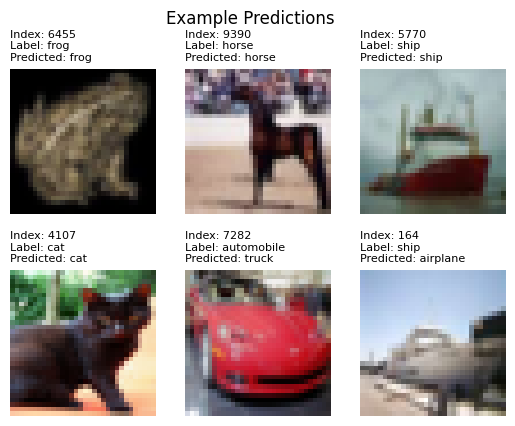

In [26]:
# plot images with predictions:
plot_6(x_test.astype(int), y_test.astype(int), y_hat=y_pred)